In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

In [2]:
startDate = '20200817'
endDate = '20200917'


readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
rawOrderLog = []
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_csv(thisPath)
    data = data.rename(columns={'mdClockAtArrival': 'caamd'})
    rawOrderLog += [data]
rawOrderLog = pd.concat(rawOrderLog, sort=False)

for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
            'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
    rawOrderLog[col] = rawOrderLog[col].astype('int64')   
rawOrderLog = rawOrderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

rawOrderLog = rawOrderLog[rawOrderLog["secid"] >= 1000000]

rawOrderLog['clock'] = rawOrderLog['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
rawOrderLog['broker'] = rawOrderLog['accCode'] // 100
rawOrderLog["broker"] = np.where(rawOrderLog["accCode"].astype(str).apply(lambda x: len(x) == 6), rawOrderLog['accCode'] // 10000, rawOrderLog["broker"])
rawOrderLog['colo_broker'] = rawOrderLog['colo'].str[:2] + '_' + rawOrderLog['broker'].astype('str')
rawOrderLog['order'] = rawOrderLog.groupby(['date', 'accCode', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['group'] = rawOrderLog.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['startClock'] = rawOrderLog.groupby(['order'])['clockAtArrival'].transform('first')
rawOrderLog['duration'] = rawOrderLog['clockAtArrival'] - rawOrderLog['startClock']
rawOrderLog['orderPrice'] = rawOrderLog['orderPrice'].apply(lambda x: round(x, 2))
rawOrderLog['tradePrice'] = rawOrderLog['tradePrice'].apply(lambda x: round(x, 2))
rawOrderLog['orderDirection1'] = np.where(rawOrderLog["orderDirection"] == -2, -1, np.where(
    rawOrderLog["orderDirection"] == 2, 1, rawOrderLog["orderDirection"]))
orderLog = rawOrderLog.copy()

### Assertion 1:  make sure same direction in same date, secid, vai
print('=======================================================================================')
print('1. same date, secid, vai: same direction')
orderLog['directNum'] = orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].transform('nunique')
if len(orderLog[orderLog['directNum'] != 1]) > 0:
    print('opposite direction for same date, same secid, same vai')
    display(orderLog[(orderLog['directNum'] != 1) & (orderLog['updateType'] == 0)][['date', 'accCode', 'secid', 'vai', 'orderDirection', 'order']])
    orderLog = orderLog[orderLog['directNum'] == 1]

assert((orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].nunique() == 1).all() == True)

## Assertion 2:  make sure each account, secid, vai only has one insertion
print('=======================================================================================')
print('2. same date, secid, vai, accCode: one insertion')
a = orderLog[orderLog['updateType'] == 0].groupby(['date', 'accCode', 'secid', 'vai', 'order'])['clockAtArrival'].count()
if len(a[a > 1]) > 0:
    print('more than one insertion at same time')
    a = a[a>1].reset_index()
    display(a)
    orderLog = orderLog[~(orderLog['order'].isin(a['order'].unique()))]

orderLog['isMsg'] = np.where(orderLog['updateType'] == 0, 
                             np.where(orderLog['mse'] == 100, 1, 0), np.nan)
orderLog['isMsg'] = orderLog.groupby(['order'])['isMsg'].ffill()

placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]
print('%.2f%% SZE orders triggered by msg data'%(placeSZE[placeSZE['isMsg'] == 1].shape[0]/placeSZE.shape[0]*100))


### Assertion 3:  check IPO stocks selling status
print('=======================================================================================')
print('3. IPO stocks selling (ars = 301, 302)')
if orderLog[orderLog['ars'].isin([301, 302])].shape[0] != 0:
    kk = orderLog[orderLog['ars'].isin([301, 302])]
    print(kk)
    try:
        assert(kk[kk['orderDirection1'] == 1].shape[0] == 0)
        print('we only sell, never buy')
    except:
        print('There are IPO buy side orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk[kk['orderDirection1'] == 1])
    kk1 = kk[kk['updateType'] == 0]
    kk1 = kk1.sort_values(by=['accCode', 'secid','clockAtArrival'])
    kk1['diff'] = kk1.groupby(['accCode', 'secid'])['clockAtArrival'].apply(lambda x: x-x.shift(1))
    kk1['diff'] = kk1['diff'].fillna(0)
    try:
        assert(kk1[kk1['diff'] < 10e6].shape[0] == 0)
        print('for each stock in the same account, there is no insertion within 10 seconds of the previous insertion')
    except:
        print('There are insertion within 10 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk1[kk1['diff'] < 10e6])
    kk2 = kk[(kk['updateType'] == 1)]
    try:
        assert(kk2[kk2['duration'] < 3e6].shape[0] == 0)
        print('for each stock in the same account, the cancellation of an order happens more than 3 seconds after the insertion')
    except:
        print('There are cancellation within 3 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk2[kk2['duration'] < 3e6])


### Assertion 4: check updateType == 7 orders, make sure updateType == 7 orders < 20 per account, < 100 in total
print('=======================================================================================')
print('4. updateType 7 orders')
if orderLog[orderLog['updateType'] == 7].shape[0] != 0:
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['order'].nunique().max() < 20)
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['order'].nunique().sum() < 100)

### Assertion 5: check updateType == 6 orders, make sure updateType == 6 orders < 5% per account
print('=======================================================================================')
print('5. updateType 6 orders')
k1 = orderLog[orderLog['updateType'] == 6].groupby('accCode')['order'].nunique().reset_index()
k2 = orderLog.groupby('accCode')['order'].nunique().reset_index()
k = pd.merge(k1, k2, on='accCode', how='left')
k['prob'] = k['order_x']/k['order_y']
try:
    assert(sum(k['prob'] >= 0.05) == 0)
except:
    print('There are accounts with more than 5% updateType 6 orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    print(k[k['prob'] >= 0.05])

### Assertion 6: check CYB orders, make sure CYB stocks total absOrderSize < 30w
print('=======================================================================================')
print('6. CYB stocks total order size < 30w')
try:
    assert(orderLog[(orderLog['secid'] >= 2300000) & (orderLog['updateType'] == 0)]['absOrderSize'].max() <= 300000)
except:
    print('CYB stocks total absOrderSize >= 30w!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    
     
### Assertion 7:  make sure there is no unexpected updateType 
print('=======================================================================================')
print('7. unexpected updateType')
def getTuple(x):
    return tuple(i for i in x)

checkLog = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4))]
checkLog = checkLog.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
checkLog['status'] = np.where(checkLog['updateType'].isin([(0, 2, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4), (0, 2, 4, 1, 4), (0, 4), (0, 1, 4), (0, 4, 1, 4), (0, 2, 2, 4), (0, 4, 2, 4), (0, 2, 2, 1, 4), (0, 2, 2, 4, 1, 4)]),0,
                     np.where(checkLog['updateType'].isin([(0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3), (0, 1, 4, 3),
                                                               (0, 2, 2, 4, 1, 3), (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 1, 4, 3), (0, 4, 2, 4, 1, 3),
                                                               (0, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 1)]), 1,
                     np.where(checkLog['updateType'].isin([(0, 2, 1, 3), (0, 2, 2, 1, 3), (0, 2, 3), (0, 3), (0, 1, 3), (0, ), (0, 2), (0, 2, 1), (0, 2, 2)]), 2, 3)))

orderLog = pd.merge(orderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
orderLog = orderLog[orderLog['status'].isin([0, 1, 2])].reset_index(drop=True)

### Assertion 8:  make sure status==0 got all traded
print('=======================================================================================')
print('8. status == 0: all traded')
a = orderLog[orderLog['status'] == 0]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in total trade, any fill != total cases')
display(a[a['filled'] != a['total']])
if a[a['filled'] != a['total']].shape[0] > 0:
    removeOrderLs = a[a['filled'] != a['total']]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### Assertion 9:  make sure status==1 got partial traded
print('=======================================================================================')
print('9. status == 1: partial traded')
a = orderLog[orderLog['status'] == 1]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in partial trade, any fill >= total or fill is 0 cases for updateType 4')
display(a[(a['filled'] >= a['total']) | (a['filled'] == 0)])
if a[(a['filled'] >= a['total']) | (a['filled'] == 0)].shape[0] > 0:
    removeOrderLs = a[(a['filled'] >= a['total']) | (a['filled'] == 0)]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### Assertion 10: make sure no cancellation within 1 sec
print('=======================================================================================')
print('10. no cancellation within 1 sec')
a = orderLog[(orderLog['updateType'] == 1) & (orderLog['duration'] < 1e6)]
print('any cancellation within 1 sec')
display(a)
if a.shape[0] > 0:
    removeOrderLs = a['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]


### Assertion 11: make sure no order has shares > 80w or notional > 800w
print('=======================================================================================')
print('11. Orders with size > 80w or notional > 800w')
orderLog['orderNtl'] = orderLog['absOrderSize'] * orderLog['orderPrice']
if orderLog[orderLog['absOrderSize'] > 800000].shape[0] > 0:
    print('some order quantity are > 80w')
    print(orderLog[orderLog['absOrderSize'] > 800000].groupby(['colo', 'accCode'])['order'].nunique())
    display(orderLog[orderLog['absOrderSize'] > 800000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                         'orderNtl', 'orderDirection', 'clock', 'order']])
            
if orderLog[orderLog['orderNtl'] > 8000000].shape[0] > 0:
    print('some order ntl are > 800w')
    print(orderLog[orderLog['orderNtl'] > 8000000].groupby(['colo', 'accCode'])['order'].nunique())
    display(orderLog[orderLog['orderNtl'] > 8000000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                      'orderNtl', 'orderDirection', 'clock', 'order', "updateType", 
                                                      "tradePrice", "absOrderSizeCumFilled", "absFilledThisUpdate"]])

removeOrderLs = list(set(orderLog[orderLog['absOrderSize'] > 800000]['order'].unique()) | set(orderLog[orderLog['orderNtl'] > 8000000]['order'].unique()))
orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]


orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
orderLog['orderNtl'] = orderLog['orderPrice'] * orderLog['absOrderSize']
orderLog['tradeNtl'] = np.where(orderLog['updateType'] == 4, orderLog['tradePrice']*orderLog['absFilledThisUpdate'], 0)
orderLog["ars"] = orderLog.groupby(['order'])['ars'].transform('first')
orderLog['sta'] = np.where(orderLog['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
orderLog

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1. same date, secid, vai: same direction
opposite direction for same date, same secid, same vai


,date,accCode,secid,vai,orderDirection,order
181375,20200817,5275,2300130,22789836,-1,4225
181381,20200817,8854,2300130,22789836,1,17799
493387,20200819,5269,2002296,7540400,1,84990
493390,20200819,6480,2002296,7540400,1,95849
493394,20200819,9741,2002296,7540400,-1,112401
553156,20200819,5470,2300492,2079008,1,92957
553159,20200819,5474,2300492,2079008,1,94183
553162,20200819,9756,2300492,2079008,-1,117151
616687,20200820,527601,1603136,829310,-1,163290
616690,20200820,975602,1603136,829310,1,169221


2. same date, secid, vai, accCode: one insertion
more than one insertion at same time


,date,accCode,secid,vai,order,clockAtArrival
0,20200817,9741,2300486,614300,33811,2
1,20200817,9741,2300812,234182,34442,2
2,20200817,9756,2300652,276800,38984,2
3,20200818,9741,1603059,338875,71977,2
4,20200818,9741,1603322,2165088,72103,2
...,...,...,...,...,...,...
1303,20200917,975602,1603016,340200,1379221,2
1304,20200917,975602,1603016,343400,1379222,2
1305,20200917,975602,1603139,329900,1379485,3
1306,20200917,975602,1603860,401500,1380280,2


87.82% SZE orders triggered by msg data
3. IPO stocks selling (ars = 301, 302)
4. updateType 7 orders
5. updateType 6 orders
6. CYB stocks total order size < 30w
7. unexpected updateType
8. status == 0: all traded
in total trade, any fill != total cases


,order,filled,total
15165,18002,3400,4300
15346,18202,3500,4000
16782,20053,3000,8800
24712,29751,1300,2300
24966,30065,12500,15100
...,...,...,...
1036834,1363646,600,2800
1041836,1370606,4200,6800
1043368,1372884,3100,3400
1044816,1375033,6000,6800


9. status == 1: partial traded
in partial trade, any fill >= total or fill is 0 cases for updateType 4


,order,filled,total


10. no cancellation within 1 sec
any cancellation within 1 sec


,Unnamed: 0,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,internalId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,l4tr,clock,broker,colo_broker,order,group,startClock,duration,orderDirection1,directNum,isMsg,status


11. Orders with size > 80w or notional > 800w
some order ntl are > 800w
colo      accCode
zt_52_04  526901     1
zt_88_03  8970       1
Name: order, dtype: int64


,date,accCode,secid,vai,absOrderSize,orderPrice,orderNtl,orderDirection,clock,order,updateType,tradePrice,absOrderSizeCumFilled,absFilledThisUpdate
47863,20200817,8970,1601318,49810664,98900,80.89,8000021.0,1,2020-08-17 10:03:24.812938,20609,0,-1.00,0,0
47864,20200817,8970,1601318,49810664,98900,80.89,8000021.0,1,2020-08-17 10:03:25.029895,20609,2,-1.00,0,0
47865,20200817,8970,1601318,49810664,98900,80.89,8000021.0,1,2020-08-17 10:03:25.438086,20609,4,80.88,1400,1400
47866,20200817,8970,1601318,49810664,98900,80.89,8000021.0,1,2020-08-17 10:03:25.440527,20609,4,80.89,1500,100
47867,20200817,8970,1601318,49810664,98900,80.89,8000021.0,1,2020-08-17 10:03:25.440710,20609,4,80.89,1600,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253417,20200818,526901,1600988,49123963,347900,23.00,8001700.0,1,2020-08-18 09:51:55.168804,77277,4,23.00,342146,500
253418,20200818,526901,1600988,49123963,347900,23.00,8001700.0,1,2020-08-18 09:51:55.169252,77277,4,23.00,342246,100
253419,20200818,526901,1600988,49123963,347900,23.00,8001700.0,1,2020-08-18 09:51:55.169697,77277,4,23.00,343246,1000
253420,20200818,526901,1600988,49123963,347900,23.00,8001700.0,1,2020-08-18 09:51:55.170122,77277,4,23.00,343446,200


,Unnamed: 0,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,internalId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,l4tr,clock,broker,colo_broker,order,group,startClock,duration,orderDirection1,directNum,isMsg,status,orderNtl,exchange,tradeNtl,sta
0,0,1597644521482187,1597644521482048,1600000,0,84071789,121.0,0,1,300,0,10.77,-1.00,20200817,537401,100,zt_52_07,NaN,698.0,NaN,140831000.0,0.002178,4849646.0,0.002420,0.002420,0.002178,-0.003221,84071789.0,1076.0,1077.0,0.0,2020-08-17 14:08:41.482187,53,zt_53,46146,0,1597644521482187,0,1,1,1.0,0,3231.0,SSE,0.0,statwo
1,1,1597644521642948,1597644521482048,1600000,2,84071789,121.0,0,1,300,0,10.77,-1.00,20200817,537401,0,zt_52_07,192323,698.0,NaN,-1.0,-1.000000,0.0,0.002420,-1.000000,0.002178,-0.003221,84071789.0,1076.0,1077.0,0.0,2020-08-17 14:08:41.642948,53,zt_53,46146,0,1597644521482187,160761,1,1,1.0,0,3231.0,SSE,0.0,statwo
2,2,1597644521784444,1597644521482048,1600000,4,84071789,121.0,300,1,300,300,10.77,10.77,20200817,537401,0,zt_52_07,NaN,698.0,25786667.0,-1.0,-1.000000,0.0,0.002420,-1.000000,0.002178,-0.003221,84071789.0,1076.0,1077.0,0.0,2020-08-17 14:08:41.784444,53,zt_53,46146,0,1597644521482187,302257,1,1,1.0,0,3231.0,SSE,3231.0,statwo
3,3,1597628235977816,1597628235977635,1600004,0,3765525,131.0,0,1,800,0,14.91,-1.00,20200817,527501,23,zt_52_05,NaN,401.0,NaN,93709000.0,0.001419,0.0,0.002929,0.002929,0.001419,-0.002012,3765525.0,1490.0,1491.0,0.0,2020-08-17 09:37:15.977816,52,zt_52,42094,1,1597628235977816,0,1,1,0.0,1,11928.0,SSE,0.0,statwo
4,4,1597628236160575,1597628235977635,1600004,2,3765525,131.0,0,1,800,0,14.91,-1.00,20200817,527501,0,zt_52_05,47924,401.0,NaN,-1.0,-1.000000,0.0,0.002929,-1.000000,0.001419,-0.002012,3765525.0,1490.0,1491.0,0.0,2020-08-17 09:37:16.160575,52,zt_52,42094,1,1597628235977816,182759,1,1,0.0,1,11928.0,SSE,0.0,statwo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5788857,324047,1600322657673194,1600322657673135,2300815,0,736300,132.0,0,1,200,0,118.71,-1.00,20200917,6683,100,zs_66_01,NaN,5449.0,NaN,140412690.0,0.001061,17973422.0,0.001754,0.001754,0.001061,-0.001838,736300.0,11870.0,11880.0,0.0,2020-09-17 14:04:17.673194,66,zs_66,1335587,910369,1600322657673194,0,1,1,1.0,1,23742.0,SZE,0.0,staone
5788858,324048,1600322657675744,1600322657673135,2300815,2,736300,132.0,0,1,200,0,118.71,-1.00,20200917,6683,0,zs_66_01,00A0QGRXTM01W2G4,5449.0,NaN,-1.0,-1.000000,0.0,0.001754,-1.000000,0.001061,-0.001838,736300.0,11870.0,11880.0,0.0,2020-09-17 14:04:17.675744,66,zs_66,1335587,910369,1600322657673194,2550,1,1,1.0,1,23742.0,SZE,0.0,staone
5788859,324049,1600322660558543,1600322658710232,2300815,4,736300,132.0,100,1,200,100,118.71,118.71,20200917,6683,0,zs_66_01,00A0QGRXTM01W2G4,5449.0,101000026087239.0,-1.0,-1.000000,0.0,0.001066,-1.000000,0.000145,-0.002562,736300.0,11871.0,11900.0,0.0,2020-09-17 14:04:20.558543,66,zs_66,1335587,910369,1600322657673194,2885349,1,1,1.0,1,23742.0,SZE,11871.0,staone
5788860,324050,1600322686381862,1600322686381811,2300815,1,736300,132.0,0,1,200,100,118.71,-1.00,20200917,6683,100,zs_66_01,00A0QGRXTM01W2G4,5449.0,NaN,-1.0,-1.000000,0.0,0.001091,-1.000000,6.7e-05,-0.000494,736600.0,11895.0,11899.0,0.0,2020-09-17 14:04:46.381862,66,zs_66,1335587,910369,1600322657673194,28708668,1,1,1.0,1,23742.0,SZE,0.0,staone


In [7]:
orderLog[orderLog['order'] == 21859]

,Unnamed: 0,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,internalId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,l4tr,clock,broker,colo_broker,order,group,startClock,duration,orderDirection1,directNum,isMsg,status,orderNtl,exchange,tradeNtl,sta
9574,9581,1597627832116631,1597627832116504,1600201,0,506640,11.0,0,-2,30400,0,29.86,-1.0,20200817,8971,22,zt_88_03,NaN,5.0,NaN,93004000.0,0.002683,0.0,0.000414,0.000414,-0.003799,0.002683,506640.0,2986.0,2990.0,0.0,2020-08-17 09:30:32.116631,89,zt_89,21859,1145,1597627832116631,0,-1,1,0.0,2,907744.0,SSE,0.0,staone
9575,9582,1597627832677616,1597627832116504,1600201,2,506640,11.0,0,-2,30400,0,29.86,-1.0,20200817,8971,0,zt_88_03,5.1e+07,5.0,NaN,-1.0,-1.000000,0.0,0.000414,-1.000000,-0.003799,0.002683,506640.0,2986.0,2990.0,0.0,2020-08-17 09:30:32.677616,89,zt_89,21859,1145,1597627832116631,560985,-1,1,0.0,2,907744.0,SSE,0.0,staone
9576,9583,1597627834182827,1597627834182722,1600201,1,506640,11.0,0,-2,30400,0,29.86,-1.0,20200817,8971,23,zt_88_03,5.1e+07,5.0,NaN,-1.0,-1.000000,0.0,0.000269,-1.000000,-0.003156,0.001313,596940.0,2974.0,2980.0,0.0,2020-08-17 09:30:34.182827,89,zt_89,21859,1145,1597627832116631,2066196,-1,1,0.0,2,907744.0,SSE,0.0,staone
9577,9584,1597627835948880,1597627835062694,1600201,3,506640,11.0,22269,-2,30400,22269,29.86,-1.0,20200817,8971,0,zt_88_03,NaN,5.0,NaN,-1.0,-1.000000,0.0,0.000252,-1.000000,-0.003966,0.000792,630540.0,2980.0,2990.0,0.0,2020-08-17 09:30:35.948880,89,zt_89,21859,1145,1597627832116631,3832249,-1,1,0.0,2,907744.0,SSE,0.0,staone


In [61]:
print('SZE')
totalAccount = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['colo_broker'] == 'zs_52')]['accCode'].unique()
for date, dateLog in orderLog[(orderLog['secid'] >= 2000000) & (orderLog['colo_broker'] == 'zs_52')].groupby(['date']):
    dailyAccount = dateLog['accCode'].unique()
    print(date, sorted(list(set(totalAccount) - set(dailyAccount))))
print(totalAccount)
print('SSE')
totalAccount = orderLog[(orderLog['secid'] < 2000000) & (orderLog['colo_broker'] == 'zt_52')]['accCode'].unique()
for date, dateLog in orderLog[(orderLog['secid'] < 2000000) & (orderLog['colo_broker'] == 'zt_52')].groupby(['date']):
    dailyAccount = dateLog['accCode'].unique()
    print(date, sorted(list(set(totalAccount) - set(dailyAccount))))
print(totalAccount)

SZE
20200824 [5222, 5225, 5226, 5286, 5287, 5289, 5290, 5291]
20200825 [5222, 5225, 5226, 5286, 5289, 5290, 5291]
20200826 [5222, 5225, 5226, 5286, 5289, 5290, 5291]
20200827 [5222, 5225, 5226, 5286, 5289, 5290, 5291]
20200828 [5222, 5225, 5226, 5289, 5290, 5291]
20200831 [5222, 5225, 5226, 5291]
20200901 [5222, 5225, 5226, 5291]
20200902 [5222, 5225, 5226, 5291]
20200903 [5222, 5225, 5226]
20200904 [5225, 5226]
20200907 [5225, 5226]
20200908 [5225, 5226]
20200909 [5225, 5226]
20200910 []
20200911 []
20200914 []
20200915 []
20200916 []
20200917 []
[5273 5275 5269 5276 5284 5281 5287 5286 5290 5289 5291 5222 5226 5225]
SSE
20200824 [522201, 522401, 522501, 522601, 528701, 528901, 529001, 529101]
20200825 [522201, 522401, 522501, 522601, 528901, 529001, 529101]
20200826 [522201, 522401, 522501, 522601, 528901, 529001, 529101]
20200827 [522201, 522401, 522501, 522601, 528901, 529001, 529101]
20200828 [522201, 522401, 522501, 522601, 528901, 529001, 529101]
20200831 [522201, 522401, 522501

### internal latency

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


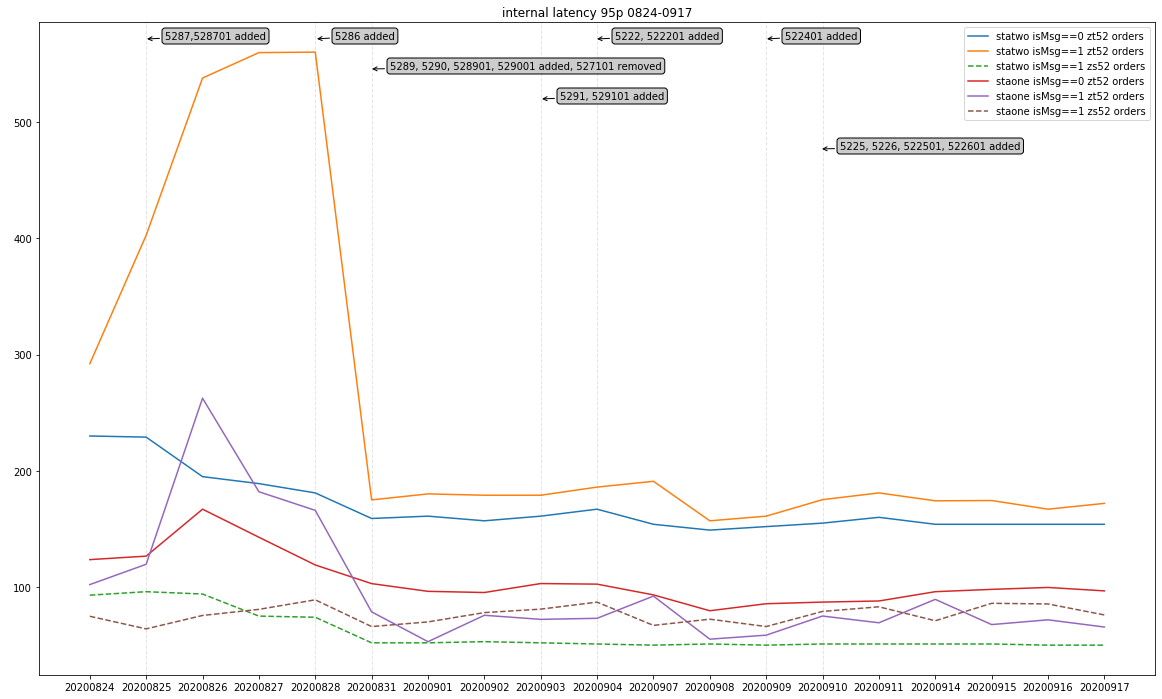

In [154]:
checkLog = orderLog[(orderLog["updateType"] == 0) & (orderLog['colo_broker'].isin(['zs_52', 'zt_52']))]
checkLog = checkLog[checkLog['caamd'] != 0]
checkLog['internal_latency'] = checkLog["clockAtArrival"] - checkLog["caamd"]
SZE = checkLog[checkLog['secid'] >= 2000000]
SSE = checkLog[checkLog['secid'] < 2000000]
SZE["exchange"] = "SZ"
SSE["exchange"] = "SH"
SZE = SZE[SZE["isMsg"] == 1]
re1 = SSE[(SSE["ars"].isin([121, 221, 321, 131, 231, 331])) & (SSE['isMsg'] == 0)].groupby('date')['internal_latency'].median().reset_index()
re2 = SSE[(SSE["ars"].isin([121, 221, 321, 131, 231, 331])) & (SSE['isMsg'] == 1)].groupby('date')['internal_latency'].median().reset_index()
re3 = SZE[(SZE["ars"].isin([121, 221, 321, 131, 231, 331]))].groupby('date')['internal_latency'].median().reset_index()
re4 = SSE[(~SSE["ars"].isin([121, 221, 321, 131, 231, 331])) & (SSE['isMsg'] == 0)].groupby('date')['internal_latency'].median().reset_index()
re5 = SSE[(~SSE["ars"].isin([121, 221, 321, 131, 231, 331])) & (SSE['isMsg'] == 1)].groupby('date')['internal_latency'].median().reset_index()
re6 = SZE[(~SZE["ars"].isin([121, 221, 321, 131, 231, 331]))].groupby('date')['internal_latency'].median().reset_index()
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111)
ax.plot(re1['internal_latency'].values, label='statwo isMsg==0 zt52 orders')
ax.plot(re2['internal_latency'].values, label='statwo isMsg==1 zt52 orders')
ax.plot(re3['internal_latency'].values, label='statwo isMsg==1 zs52 orders', linestyle='dashed')
ax.plot(re4['internal_latency'].values, label='staone isMsg==0 zt52 orders')
ax.plot(re5['internal_latency'].values, label='staone isMsg==1 zt52 orders')
ax.plot(re6['internal_latency'].values, label='staone isMsg==1 zs52 orders', linestyle='dashed')

ax.set_title('internal latency 95p 0824-0917')
indexLs = [i for i in range(re1.shape[0])]
dateLs = [int(i) for i in re1['date'].values]
ax.set_xticks(indexLs)
ax.set_xticklabels(dateLs)
fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.axvline(x=1,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=4,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=5,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=8,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=9,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=12,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=13,ls="--",c="grey", alpha=0.2, lw=1)
bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle = "->")
ax.annotate('5287,528701 added', (145, 660), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5286 added', (315, 660), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5289, 5290, 528901, 529001 added, 527101 removed', (370, 630), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5291, 529101 added', (540, 600), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5222, 522201 added', (595, 660), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('522401 added', (765, 660), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5225, 5226, 522501, 522601 added', (820, 550), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)

plt.show()

### fill rate 

In [163]:
order_list = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 0) & (orderLog['colo_broker'] == 'zt_52')
             & (orderLog["ars"].isin([121, 221, 321, 131, 231, 331])) & (orderLog['isMsg'] == 0)]['order'].unique()
d1 = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 0) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['orderNtl'].sum().reset_index()
d2 = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 4) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['tradeNtl'].sum().reset_index()
re1 = pd.merge(d1, d2, on=['date', 'exchange', 'colo_broker'])
re1['fill rate'] = re1['tradeNtl'] / re1['orderNtl']
order_list = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 0) & (orderLog['colo_broker'] == 'zt_52')
             & (orderLog["ars"].isin([121, 221, 321, 131, 231, 331])) & (orderLog['isMsg'] == 1)]['order'].unique()
d1 = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 0) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['orderNtl'].sum().reset_index()
d2 = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 4) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['tradeNtl'].sum().reset_index()
re2 = pd.merge(d1, d2, on=['date', 'exchange', 'colo_broker'])
re2['fill rate'] = re2['tradeNtl'] / re2['orderNtl']
order_list = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 0) & (orderLog['colo_broker'] == 'zt_52')
             & (~orderLog["ars"].isin([121, 221, 321, 131, 231, 331])) & (orderLog['isMsg'] == 0)]['order'].unique()
d1 = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 0) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['orderNtl'].sum().reset_index()
d2 = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 4) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['tradeNtl'].sum().reset_index()
re4 = pd.merge(d1, d2, on=['date', 'exchange', 'colo_broker'])
re4['fill rate'] = re4['tradeNtl'] / re4['orderNtl']
order_list = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 0) & (orderLog['colo_broker'] == 'zt_52')
             & (~orderLog["ars"].isin([121, 221, 321, 131, 231, 331])) & (orderLog['isMsg'] == 1)]['order'].unique()
d1 = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 0) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['orderNtl'].sum().reset_index()
d2 = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 4) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['tradeNtl'].sum().reset_index()
re5 = pd.merge(d1, d2, on=['date', 'exchange', 'colo_broker'])
re5['fill rate'] = re5['tradeNtl'] / re5['orderNtl']

,date,exchange,colo_broker,orderNtl,tradeNtl,fill rate
0,20200824,SSE,zt_52,33346708.16,28658776.68,0.859418
1,20200825,SSE,zt_52,40195694.32,32857679.19,0.817443
2,20200826,SSE,zt_52,26377259.00,21321599.00,0.808333
3,20200827,SSE,zt_52,20614273.00,16472970.76,0.799105
4,20200828,SSE,zt_52,16380347.82,13291945.82,0.811457
5,20200831,SSE,zt_52,11176356.00,8564967.70,0.766347
6,20200901,SSE,zt_52,15514463.50,12008647.85,0.774029
7,20200902,SSE,zt_52,15401609.00,7940392.49,0.515556
8,20200903,SSE,zt_52,10006437.16,8299522.16,0.829418
9,20200904,SSE,zt_52,21688466.12,15499397.26,0.714638


In [165]:
order_list = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 0) & (orderLog['colo_broker'] == 'zs_52')
             & (orderLog["ars"].isin([121, 221, 321, 131, 231, 331])) & (orderLog['isMsg'] == 1)]['order'].unique()
d1 = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 0) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['orderNtl'].sum().reset_index()
d2 = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 4) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['tradeNtl'].sum().reset_index()
re3 = pd.merge(d1, d2, on=['date', 'exchange', 'colo_broker'])
re3['fill rate'] = re3['tradeNtl'] / re3['orderNtl']
order_list = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 0) & (orderLog['colo_broker'] == 'zs_52')
             & (~orderLog["ars"].isin([121, 221, 321, 131, 231, 331])) & (orderLog['isMsg'] == 1)]['order'].unique()
d1 = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 0) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['orderNtl'].sum().reset_index()
d2 = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 4) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['tradeNtl'].sum().reset_index()
re6 = pd.merge(d1, d2, on=['date', 'exchange', 'colo_broker'])
re6['fill rate'] = re6['tradeNtl'] / re6['orderNtl']
re6

,date,exchange,colo_broker,orderNtl,tradeNtl,fill rate
0,20200824,SZE,zs_52,6.841719e+07,6.405156e+07,0.936191
1,20200825,SZE,zs_52,8.532692e+07,7.956431e+07,0.932464
2,20200826,SZE,zs_52,1.170861e+08,1.072224e+08,0.915756
3,20200827,SZE,zs_52,5.252912e+07,4.817769e+07,0.917162
4,20200828,SZE,zs_52,6.350991e+07,5.422550e+07,0.853812
5,20200831,SZE,zs_52,8.400374e+07,7.010024e+07,0.834490
6,20200901,SZE,zs_52,5.853965e+07,4.971697e+07,0.849287
7,20200902,SZE,zs_52,9.089754e+07,8.090084e+07,0.890022
8,20200903,SZE,zs_52,7.562230e+07,6.278958e+07,0.830305
9,20200904,SZE,zs_52,1.415046e+08,1.138138e+08,0.804312


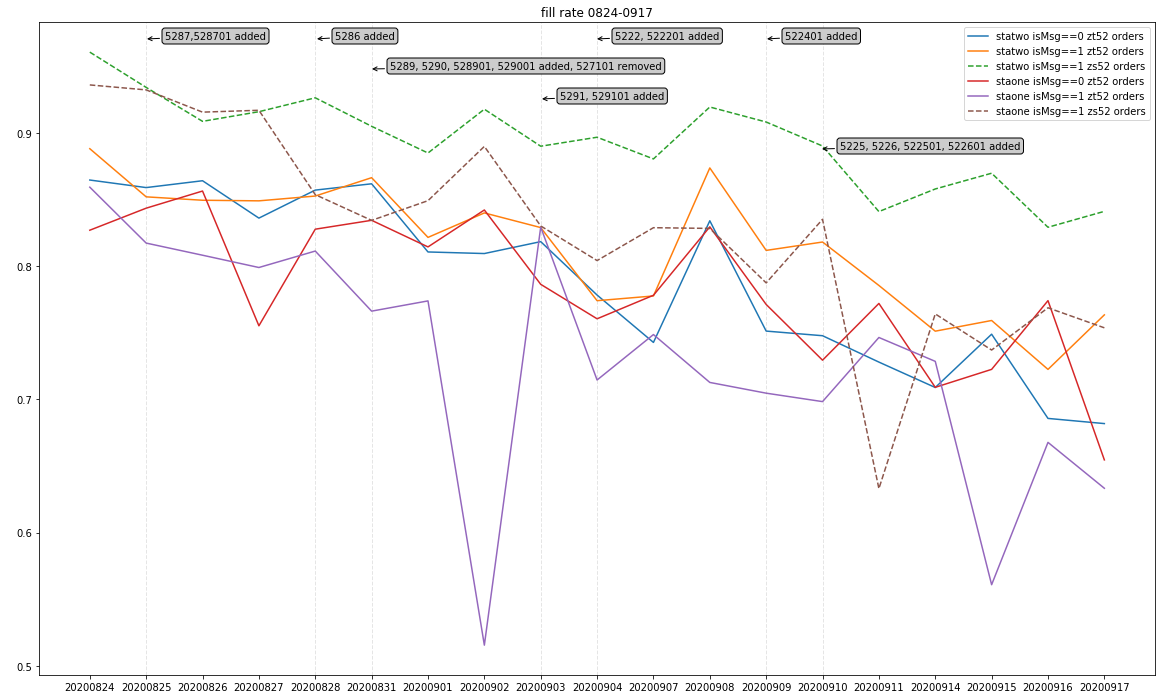

In [166]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111)
ax.plot(re1['fill rate'].values, label='statwo isMsg==0 zt52 orders')
ax.plot(re2['fill rate'].values, label='statwo isMsg==1 zt52 orders')
ax.plot(re3['fill rate'].values, label='statwo isMsg==1 zs52 orders', linestyle='dashed')
ax.plot(re4['fill rate'].values, label='staone isMsg==0 zt52 orders')
ax.plot(re5['fill rate'].values, label='staone isMsg==1 zt52 orders')
ax.plot(re6['fill rate'].values, label='staone isMsg==1 zs52 orders', linestyle='dashed')

ax.set_title('fill rate 0824-0917')
indexLs = [i for i in range(re1.shape[0])]
dateLs = [int(i) for i in re1['date'].values]
ax.set_xticks(indexLs)
ax.set_xticklabels(dateLs)
fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.axvline(x=1,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=4,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=5,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=8,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=9,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=12,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=13,ls="--",c="grey", alpha=0.2, lw=1)
bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle = "->")
ax.annotate('5287,528701 added', (145, 660), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5286 added', (315, 660), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5289, 5290, 528901, 529001 added, 527101 removed', (370, 630), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5291, 529101 added', (540, 600), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5222, 522201 added', (595, 660), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('522401 added', (765, 660), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5225, 5226, 522501, 522601 added', (820, 550), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)

plt.show()

### tickToMBD

In [62]:
startDate = '20200824'
endDate = '20200917'
readPath = r'L:\orderLog\result\marketPos'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'SZspeed_***.pkl')))
dateLs = np.array([os.path.basename(i).split('.')[0].split('_')[1] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
checkData = []
for path in dataPathLs:
    data = pd.read_pickle(path)
    checkData += [data]
checkLog = pd.concat(checkData).reset_index(drop=True)   
display(checkLog['date'].unique())

checkLog = checkLog.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
checkLog = checkLog[~checkLog['accCode'].isnull()]
checkLog = checkLog.reset_index(drop=True)
checkLog['ordering'] = checkLog.index
checkLog['time_diff'] = checkLog['clockAtArrival'] - checkLog['start_time']
checkLog['colo1'] = checkLog['colo'].str[:2]
checkLog['colo_broker'] = checkLog['colo1'] + '_' + checkLog["accCode"].astype(str).str[:2]
checkLog = checkLog[checkLog['colo_broker'] == 'zs_52']
checkLog['accCode'] = checkLog['accCode'].astype(int)
checkLog['sta'] = np.where(checkLog['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
checkLog1 = checkLog[checkLog['sta'] == 'statwo']

from IPython.display import display, HTML
re1 = checkLog1.groupby(['sta', 'date', 'colo'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog1.groupby(['sta', 'date', 'colo'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['sta','date',  'colo', '10%']], on=['sta', 'date', 'colo'])
c1 = checkLog1.groupby(['sta', 'date', 'colo'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['sta', 'date', 'colo', '90%']], on=['sta', 'date', 'colo'])

display(HTML(re1[['sta', 'date',  'colo', 'count',  '10%', '25%', '50%', '75%', '90%']].groupby(['sta','date',  'colo']).first().to_html()))

checkLog3 = checkLog[(checkLog['sta'] == 'staone')]
from IPython.display import display, HTML
re2 = checkLog3.groupby(['sta', 'date', 'colo'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog3.groupby(['sta', 'date', 'colo'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re2 = pd.merge(re2, c1[['sta', 'date', 'colo', '10%']], on=['sta', 'date', 'colo'])
c1 = checkLog3.groupby(['sta', 'date', 'colo'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re2 = pd.merge(re2, c1[['sta', 'date', 'colo', '90%']], on=['sta', 'date', 'colo'])

display(HTML(re2[['sta', 'date', 'colo', 'count',  '10%', '25%', '50%', '75%', '90%']].groupby(['sta', 'date', 'colo']).first().to_html()))

array([20200824, 20200825, 20200826, 20200827, 20200828, 20200907,
       20200908, 20200831, 20200901, 20200902, 20200903, 20200904,
       20200909, 20200910, 20200911, 20200914, 20200915, 20200916,
       20200917], dtype=int64)

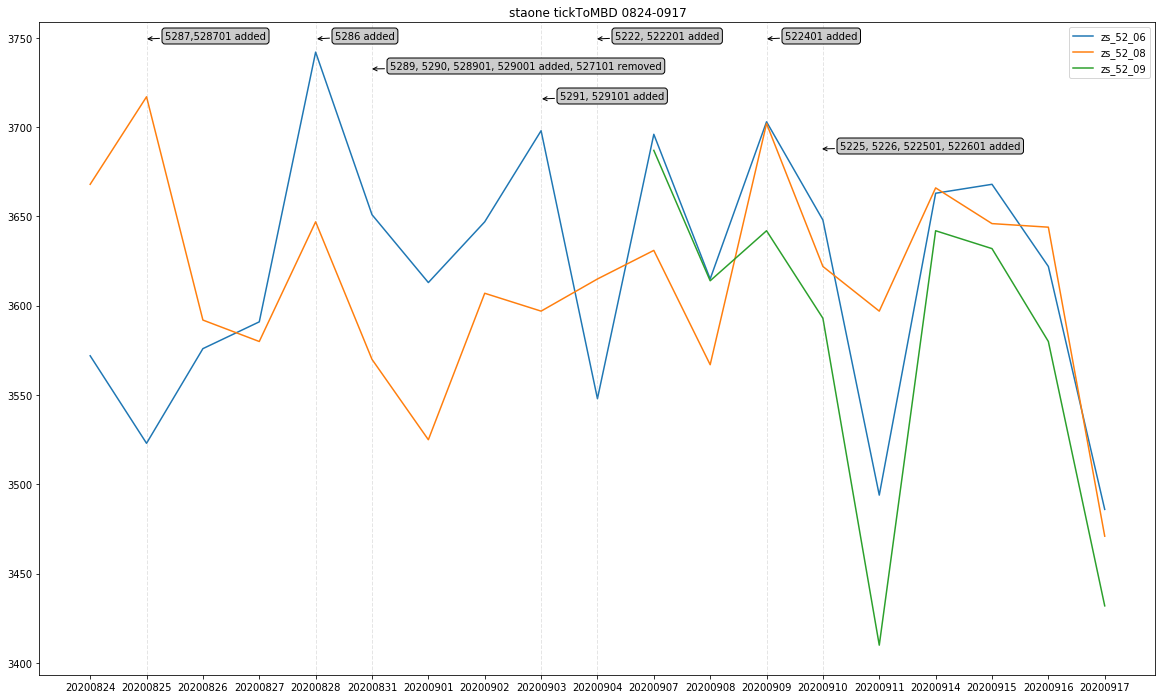

In [64]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111)
# for i in re2[re2['date'] < re2[re2['colo'] == 'zs_52_09']['date'].min()]['date'].unique():
#     re2 = re2.append([{'colo':'zs_52_09', 'date':i}], ignore_index=True)

re2 = re2.sort_values(by=['date', 'colo'])
ax.plot(re2[re2['colo'] == 'zs_52_06']['50%'].values, label='zs_52_06')
ax.plot(re2[re2['colo'] == 'zs_52_08']['50%'].values, label='zs_52_08')
ax.plot(re2[re2['colo'] == 'zs_52_09']['50%'].values, label='zs_52_09')

ax.set_title('staone tickToMBD 0824-0917')
indexLs = [i for i in range(re2[re2['colo'] == 'zs_52_06'].shape[0])]
dateLs = [int(i) for i in re2[re2['colo'] == 'zs_52_06']['date'].values]
ax.set_xticks(indexLs)
ax.set_xticklabels(dateLs)
fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.axvline(x=1,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=4,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=5,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=8,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=9,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=12,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=13,ls="--",c="grey", alpha=0.2, lw=1)
bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle = "->")
ax.annotate('5287,528701 added', (145, 660), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5286 added', (315, 660), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5289, 5290, 528901, 529001 added, 527101 removed', (370, 630), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5291, 529101 added', (540, 600), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5222, 522201 added', (595, 660), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('522401 added', (765, 660), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5225, 5226, 522501, 522601 added', (820, 550), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)

plt.show()

### internal competitive rate

In [9]:
checkLog = orderLog[orderLog['updateType'] == 0].reset_index(drop=True)
checkLog['brokerNum'] = checkLog.groupby(['date', 'secid', 'vai'])['accCode'].transform('nunique')
order_list = checkLog[(checkLog['exchange'] == 'SSE') & (checkLog['colo_broker'] == 'zt_52')
             & (checkLog["brokerNum"] >= 2)]['order'].unique()
d1 = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 0) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['orderNtl'].sum().reset_index()
d2 = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 4) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['tradeNtl'].sum().reset_index()
re1 = pd.merge(d1, d2, on=['date', 'exchange', 'colo_broker'])
re1['fill rate'] = re1['tradeNtl'] / re1['orderNtl']

order_list = checkLog[(checkLog['exchange'] == 'SSE') & (checkLog['colo_broker'] == 'zt_52')
             & (checkLog["brokerNum"] == 1)]['order'].unique()
d1 = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 0) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['orderNtl'].sum().reset_index()
d2 = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 4) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['tradeNtl'].sum().reset_index()
re2 = pd.merge(d1, d2, on=['date', 'exchange', 'colo_broker'])
re2['fill rate'] = re2['tradeNtl'] / re2['orderNtl']

order_list = checkLog[(checkLog['exchange'] == 'SZE') & (checkLog['colo_broker'] == 'zs_52')
             & (checkLog["brokerNum"] >= 2)]['order'].unique()
d1 = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 0) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['orderNtl'].sum().reset_index()
d2 = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 4) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['tradeNtl'].sum().reset_index()
re3 = pd.merge(d1, d2, on=['date', 'exchange', 'colo_broker'])
re3['fill rate'] = re3['tradeNtl'] / re3['orderNtl']

order_list = checkLog[(checkLog['exchange'] == 'SZE') & (checkLog['colo_broker'] == 'zs_52')
             & (checkLog["brokerNum"] == 1)]['order'].unique()
d1 = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 0) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['orderNtl'].sum().reset_index()
d2 = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 4) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['tradeNtl'].sum().reset_index()
re4 = pd.merge(d1, d2, on=['date', 'exchange', 'colo_broker'])
re4['fill rate'] = re4['tradeNtl'] / re4['orderNtl']

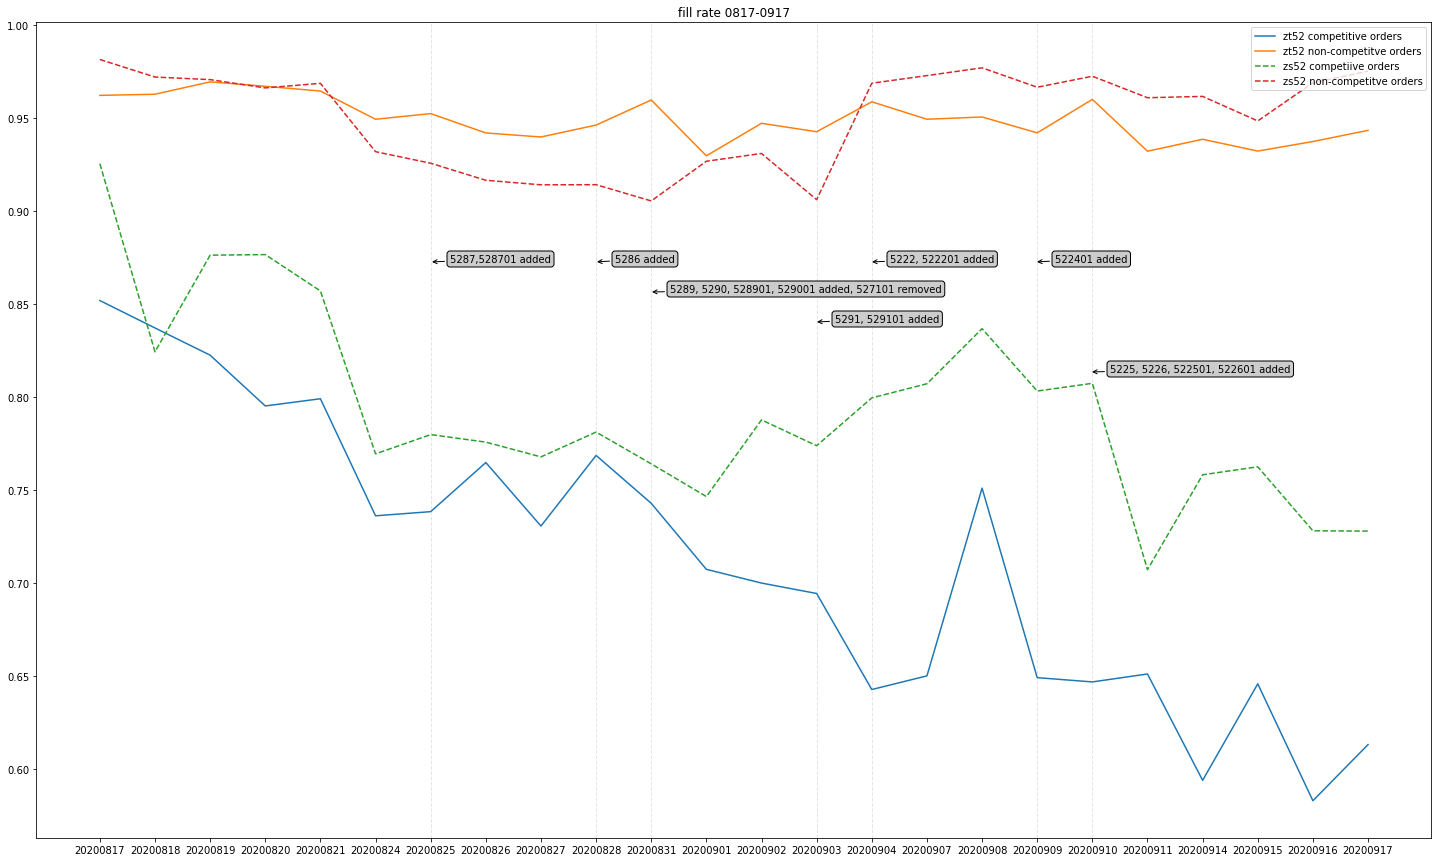

In [18]:
fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(111)
ax.plot(re1['fill rate'].values, label='zt52 competitive orders')
ax.plot(re2['fill rate'].values, label='zt52 non-competitve orders')
ax.plot(re3['fill rate'].values, label='zs52 competiive orders', linestyle='dashed')
ax.plot(re4['fill rate'].values, label='zs52 non-competitve orders', linestyle='dashed')


ax.set_title('fill rate 0817-0917')
indexLs = [i for i in range(re1.shape[0])]
dateLs = [int(i) for i in re1['date'].values]
ax.set_xticks(indexLs)
ax.set_xticklabels(dateLs)
fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.axvline(x=6,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=9,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=10,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=13,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=14,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=17,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=18,ls="--",c="grey", alpha=0.2, lw=1)
bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle = "->")
ax.annotate('5287,528701 added', (430, 600), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5286 added', (595, 600), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5289, 5290, 528901, 529001 added, 527101 removed', (650, 570), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5291, 529101 added', (815, 540), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5222, 522201 added', (870, 600), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('522401 added', (1035, 600), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5225, 5226, 522501, 522601 added', (1090, 490), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)

plt.show()

In [3]:
orderLog['sta'] = np.where(orderLog['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
orderLog["ApplSeqNum"] = orderLog.groupby(['order'])['ApplSeqNum'].transform('first')
checkLog = orderLog[orderLog['updateType'] == 0].reset_index(drop=True)
checkLog['brokerNum'] = checkLog.groupby(['date', 'secid', 'vai'])['accCode'].transform('nunique')

checkLog1 = checkLog[checkLog['sta'] == 'staone']
checkLog2 = checkLog[checkLog['sta'] == 'statwo']

re1 = checkLog2[(checkLog2['brokerNum'] >= 2) & (checkLog2['colo_broker'] == 'zt_52')].groupby('date')['ars'].size().reset_index()
re1 = pd.merge(re1, checkLog2[(checkLog2['colo_broker'] == 'zt_52')].groupby('date')['ars'].size().reset_index(), on='date')
# re1 = pd.merge(re1, checkLog2[(checkLog2['colo_broker'] == 'zt_52') & (checkLog2['ApplSeqNum'] == 0) & (checkLog2['brokerNum'] >= 2)].groupby('date')['ars'].size().reset_index(), on='date')
re1['perc'] = re1['ars_x']/re1['ars_y']
# re1['perc1'] = re1['ars']/re1['ars_y']
re2 = checkLog2[(checkLog2['brokerNum'] >= 2) & (checkLog2['colo_broker'] == 'zs_52')].groupby('date')['ars'].size().reset_index()
re2 = pd.merge(re2, checkLog2[(checkLog2['colo_broker'] == 'zs_52')].groupby('date')['ars'].size().reset_index(), on='date')
# re2 = pd.merge(re2, checkLog2[(checkLog2['colo_broker'] == 'zs_52') & (checkLog2['ApplSeqNum'] == 0) & (checkLog2['brokerNum'] >= 2)].groupby('date')['ars'].size().reset_index(), on='date')
re2['perc'] = re2['ars_x']/re2['ars_y']
# re2['perc1'] = re2['ars']/re2['ars_y']

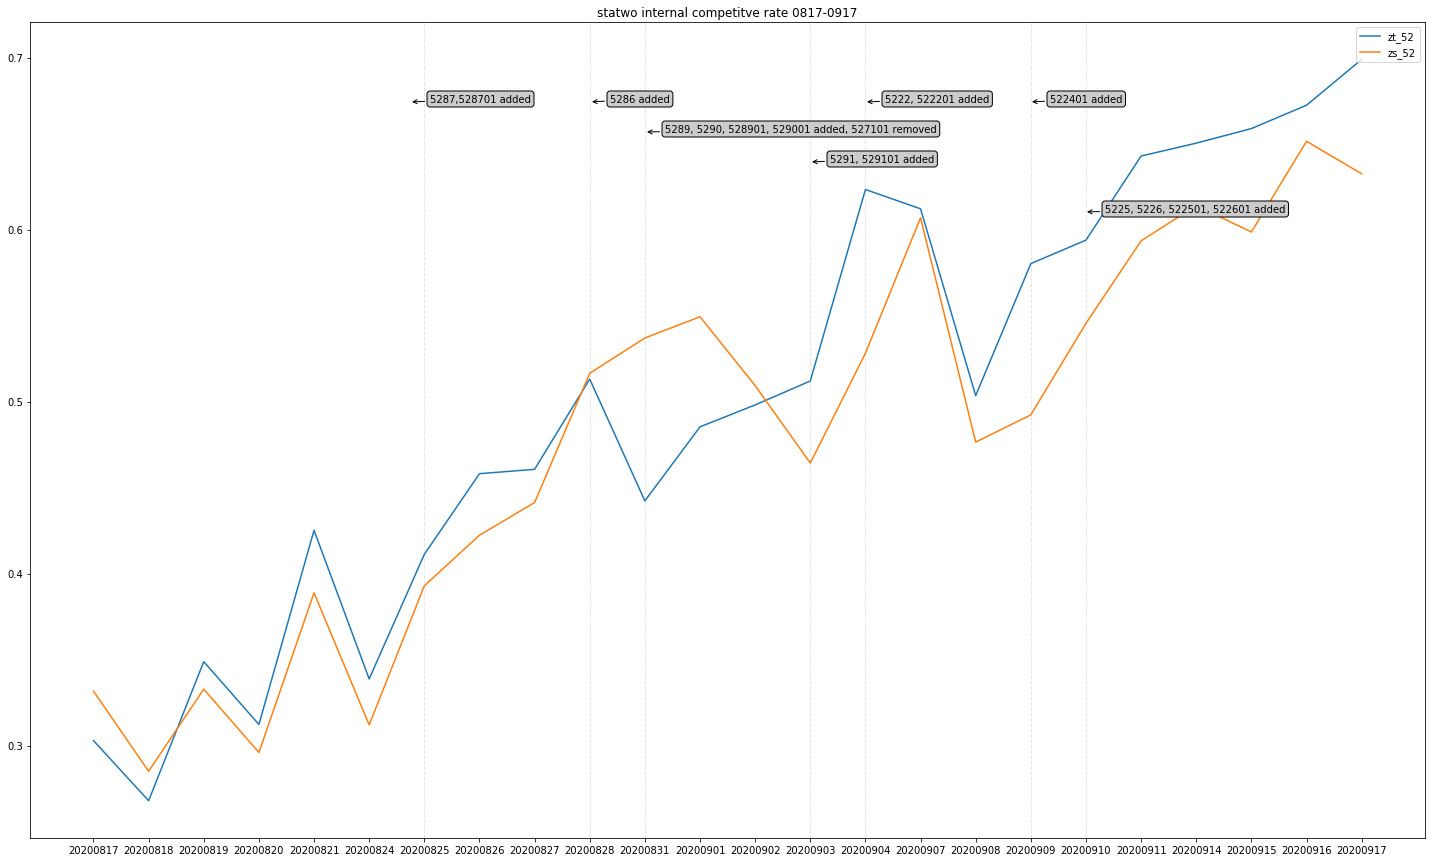

In [4]:
fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(111)

ax.plot(re1['perc'].values, label='zt_52')
ax.plot(re2['perc'].values, label='zs_52')

ax.set_title('statwo internal competitve rate 0817-0917')
indexLs = [i for i in range(re1.shape[0])]
dateLs = [int(i) for i in re1['date'].values]
ax.set_xticks(indexLs)
ax.set_xticklabels(dateLs)
fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.axvline(x=6,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=9,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=10,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=13,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=14,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=17,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=18,ls="--",c="grey", alpha=0.2, lw=1)
bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle = "->")
ax.annotate('5287,528701 added', (410, 760), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5286 added', (590, 760), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5289, 5290, 528901, 529001 added, 527101 removed', (645, 730), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5291, 529101 added', (810, 700), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5222, 522201 added', (865, 760), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('522401 added', (1030, 760), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5225, 5226, 522501, 522601 added', (1085, 650), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)

plt.show()



### orderNtl, tradeNtl

In [211]:
d1 = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 0) & (orderLog['colo_broker'] == 'zs_52')].groupby(['date', 'exchange'])['orderNtl'].sum().reset_index()
d2 = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 4) & (orderLog['colo_broker'] == 'zs_52')].groupby(['date', 'exchange'])['tradeNtl'].sum().reset_index()
re1 = pd.merge(d1, d2, on=['date', 'exchange'])
re1['perc'] = re1['tradeNtl'] / re1['orderNtl']
re1

,date,exchange,orderNtl,tradeNtl,perc
0,20200817,SZE,6.433976e+08,6.181760e+08,0.960799
1,20200818,SZE,5.242608e+08,4.867047e+08,0.928364
2,20200819,SZE,5.826252e+08,5.444249e+08,0.934434
3,20200820,SZE,5.655352e+08,5.298005e+08,0.936813
4,20200821,SZE,6.674495e+08,6.177028e+08,0.925467
5,20200824,SZE,6.235968e+08,5.350510e+08,0.858008
6,20200825,SZE,6.411446e+08,5.518641e+08,0.860748
7,20200826,SZE,9.080341e+08,7.693523e+08,0.847273
8,20200827,SZE,7.486084e+08,6.280671e+08,0.838979
9,20200828,SZE,8.281806e+08,6.956847e+08,0.840016


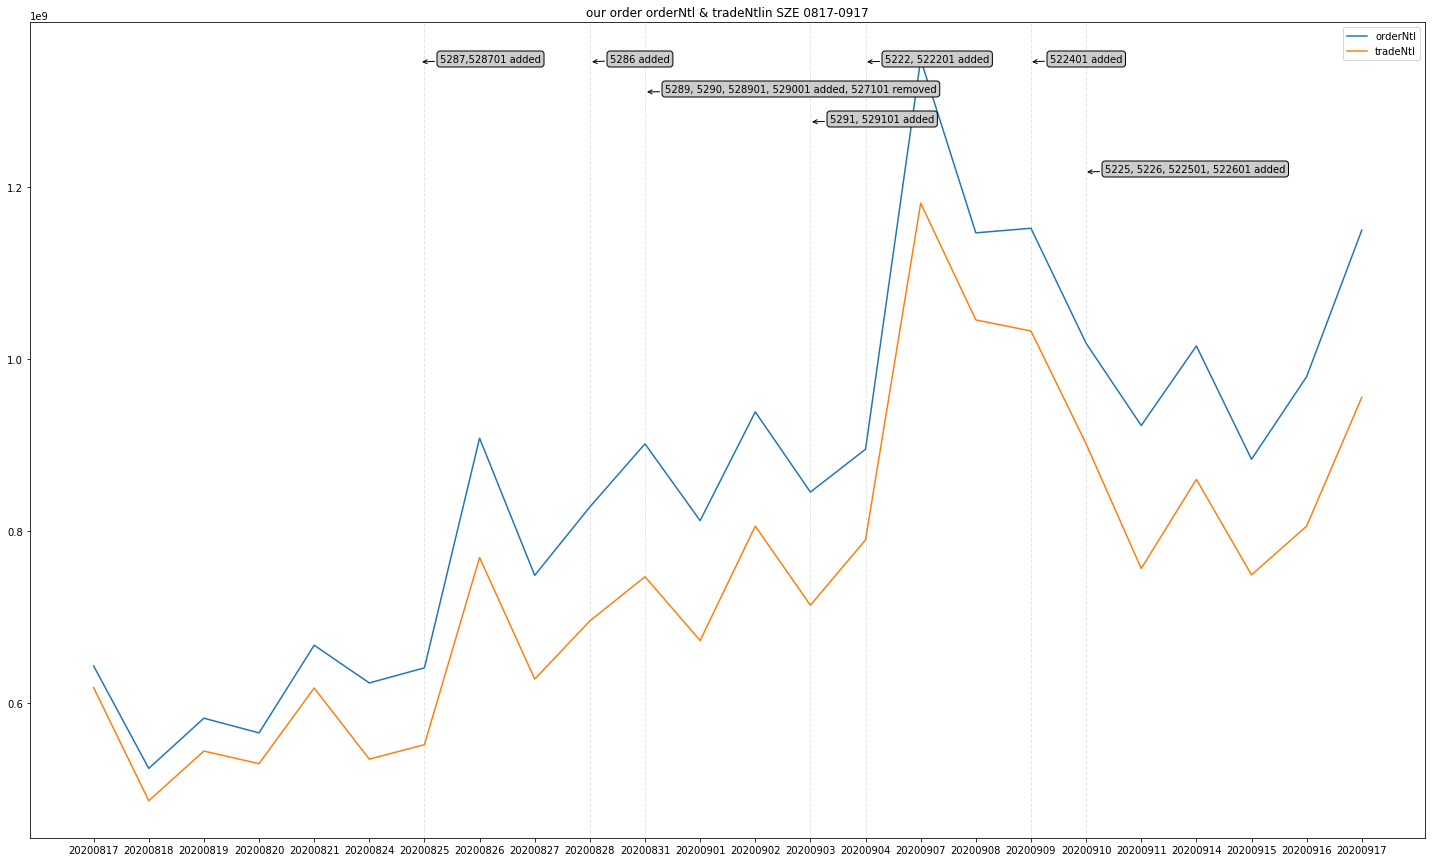

In [183]:
fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(111)

ax.plot(re1['orderNtl'].values, label='orderNtl')
ax.plot(re1['tradeNtl'].values, label='tradeNtl')

ax.set_title('our order orderNtl & tradeNtlin SZE 0817-0917')
indexLs = [i for i in range(re1.shape[0])]
dateLs = [int(i) for i in re1['date'].values]
ax.set_xticks(indexLs)
ax.set_xticklabels(dateLs)
fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.axvline(x=6,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=9,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=10,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=13,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=14,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=17,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=18,ls="--",c="grey", alpha=0.2, lw=1)
bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle = "->")
ax.annotate('5287,528701 added', (420, 800), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5286 added', (590, 800), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5289, 5290, 528901, 529001 added, 527101 removed', (645, 770), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5291, 529101 added', (810, 740), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5222, 522201 added', (865, 800), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('522401 added', (1030, 800), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5225, 5226, 522501, 522601 added', (1085, 690), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)

plt.show()

In [207]:
def clean(x):
    cl_ean = x["ListDays"] != 0
    x = x[cl_ean]
#     cl_ean1 = x["trade_stats"] == 1
#     x = x[cl_ean1]
    return x.iloc[:,[0,1,2,3,5,6,7,8,9,10,11,12,13]]

startDate = '20200817'
endDate = '20200917'
path = r'F:\Download\StockFactors'
all_files = np.array(glob.glob(os.path.join(path, "*.csv")))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in all_files])
all_files = all_files[(dateLs >= startDate) & (dateLs <= endDate)]

dd = clean(pd.read_csv(all_files[0], encoding="GBK"))
for i in range(1, len(all_files)):
    dn = clean(pd.read_csv(all_files[i], encoding="GBK"))
    dd = pd.concat([dd, dn], axis = 0, ignore_index = True)
dd = dd.sort_values(by=["Date"])
dd['exchange'] = np.where(dd['Symbol'].str[:2] == 'SH', 'SH', 'SZ')
re2 = dd.groupby(['exchange', 'Date'])['amt'].sum().reset_index()
re2

,exchange,Date,amt
0,SH,20200817,5.372364e+11
1,SH,20200818,4.929007e+11
2,SH,20200819,4.980412e+11
3,SH,20200820,4.016786e+11
4,SH,20200821,3.611536e+11
5,SH,20200824,3.453699e+11
6,SH,20200825,3.557810e+11
7,SH,20200826,3.813683e+11
8,SH,20200827,3.168808e+11
9,SH,20200828,3.789908e+11


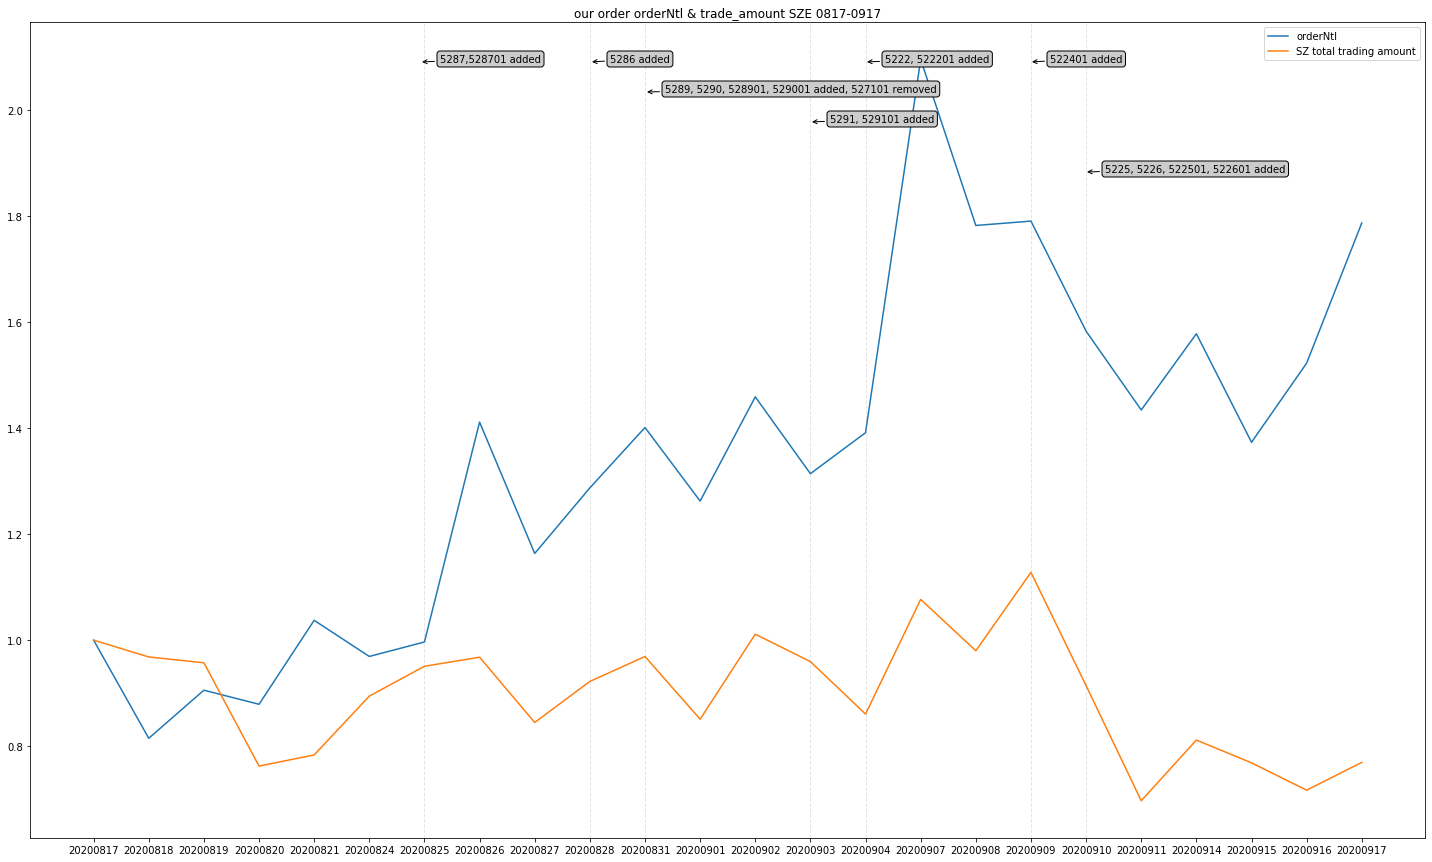

In [212]:
fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(111)

ax.plot(re1['orderNtl'].values/re1['orderNtl'].iloc[0], label='orderNtl')
ax.plot(re2[re2['exchange'] == 'SZ']['amt'].values/re2[re2['exchange'] == 'SZ']['amt'].iloc[0], label='SZ total trading amount')

ax.set_title('our order orderNtl & trade_amount SZE 0817-0917')
indexLs = [i for i in range(re1.shape[0])]
dateLs = [int(i) for i in re1['date'].values]
ax.set_xticks(indexLs)
ax.set_xticklabels(dateLs)
fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.axvline(x=6,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=9,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=10,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=13,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=14,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=17,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=18,ls="--",c="grey", alpha=0.2, lw=1)
bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle = "->")
ax.annotate('5287,528701 added', (420, 800), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5286 added', (590, 800), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5289, 5290, 528901, 529001 added, 527101 removed', (645, 770), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5291, 529101 added', (810, 740), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5222, 522201 added', (865, 800), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('522401 added', (1030, 800), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)
ax.annotate('5225, 5226, 522501, 522601 added', (1085, 690), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)

plt.show()

In [213]:
re2[re2['exchange'] == 'SZ']

,exchange,Date,amt
24,SZ,20200817,6.163955e+11
25,SZ,20200818,5.968210e+11
26,SZ,20200819,5.900598e+11
27,SZ,20200820,4.699380e+11
28,SZ,20200821,4.828870e+11
29,SZ,20200824,5.512915e+11
30,SZ,20200825,5.859859e+11
31,SZ,20200826,5.965405e+11
32,SZ,20200827,5.206498e+11
33,SZ,20200828,5.683935e+11
